#2. GRU encoder-decoder with attention (pre-trained embeddings)

The following architecture is composed of of a GRU encoder and a GRU decoder, with an attention layer. Again we use MLP attention and the energy formula $s_i = a^T tanh (W_d d_t + W_s h_i)$. We use pretrained embeddings from BERT base uncased. The dimension of the embedding layer is 512 for both the encoder and the decoder. Again we use Adam optimiser with a learning rate of 0.001,cross-entropy loss and 0.5 dropout. Both models regardless of their input use the same vocabulary and have 72,848,954 tunable parameters. Both models are trained for 100 epochs.

In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.3MB 14.3MB/s 
     |████████████████████████████████| 3.3MB 51.6MB/s 
     |████████████████████████████████| 901kB 49.5MB/s 
     |████████████████████████████████| 1.2MB 13.4MB/s 


In [ ]:
#import statements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, Dataset, Example, LabelField

import spacy
import numpy as np
import pandas as pd

import random
import math
import time

import nltk
nltk.download('punkt')

import tensorflow as tf
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel , Adafactor
from transformers import get_linear_schedule_with_warmup

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#set seed
SEED = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

##2a) Non-empathetic response as input

In [ ]:
#import csv file into pandas dataframe
data_df = pd.read_csv('drive/MyDrive/data.csv', encoding="latin1")

In [ ]:
#define device
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
GPU in use: Tesla P100-PCIE-16GB


In [ ]:
#embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
vocab_size = len( BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True).get_vocab() )
vocab_size

30522

In [ ]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

#parameters for the dataset and dataloader
BATCH_SIZE = 32
max_sent_length= 150

#################################### Preprocessing function ####################################
def preprocessing(df):

    #get the source and target sentences
    source_sentences = df.source.values
    target_sentences = df.target.values

    # initialize the tokenizer for tokenize the sentence and obtain the indexed list using bert vocabulary
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)
    
    encoded_source_sentences , encoded_target_sentences = [] , []
    # iterate over every source , target sentence and tokenize them
    for s_sent , t_sent in zip(source_sentences , target_sentences ):
        #source sentence tokenization
        s_encoded_sent = tokenizer.encode(
                            s_sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = max_sent_length
                    )
        # target sentence tokenization
        t_encoded_sent = tokenizer.encode(
                            t_sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = max_sent_length
                    )


        encoded_source_sentences.append(s_encoded_sent)
        encoded_target_sentences.append(t_encoded_sent)


    
    return encoded_source_sentences, encoded_target_sentences

In [ ]:
#split into train, val and test sets (80-10-10)
train_df, val_df, test_df = \
              np.split(data_df.sample(frac=1, random_state=42), 
                       [int(.8*len(data_df)), int(.9*len(data_df))])

In [ ]:
# get the encoded source and target sentence
train_source_sentences, train_target_sentences = preprocessing(train_df)
val_source_sentences, val_target_sentences = preprocessing(val_df)
test_source_sentences, test_target_sentences = preprocessing(test_df)

In [ ]:
#define the torch dataset class to feed into the model
class Seq2SeqDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    # class initialization with max sequence len , target and source sentence list
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 
        """
        self.data_list = data_list   # source sentence list
        self.target_list = target_list  # target sentence list
        self.max_sent_length = max_sent_length   # maximum sentence lenght
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    # return the source and target sentences
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    # we use this collate_fn to dynamically pad the batch according to the maximum len inside the sentences
    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] 
        target_list = []
        mask_list = []

        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
        """
        
        # find the max sequence length from the batch
        max_batch_s_len = max(len(datum[0]) for datum in batch)
        max_batch_t_len = max(len(datum[1]) for datum in batch)

        #get the maximum from source and target lens
        max_batch_seq_len = max(  [  max_batch_s_len , max_batch_t_len ] )

        if max_batch_seq_len > self.max_sent_length:
          max_batch_seq_len = self.max_sent_length

        # pad each of the texts in batch wit constant 0
        for datum in batch:
          # padding the source vector
          padded_s_vec = np.pad(np.array(datum[0]),
                              pad_width = ((0, max_batch_seq_len - len(datum[0]))),
                              mode = "constant", constant_values = 0)
          # padding the target vector
          padded_t_vec = np.pad(np.array(datum[1]),
                              pad_width = ((0, max_batch_seq_len - len(datum[1]))),
                              mode = "constant", constant_values = 0)

          data_list.append(padded_s_vec)
          target_list.append( padded_t_vec )


        # convert to torch tensors 
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.from_numpy( np.array(target_list)  )

        return [data_list, label_list]

In [ ]:
#define the train dataset and the data loader 
train_dataset = Seq2SeqDataset( train_source_sentences , train_target_sentences , max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

# define the validation dataset and the dataloader
valid_dataset = Seq2SeqDataset( val_source_sentences , val_target_sentences , train_dataset.max_sent_length)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

# define the test dataset and the dataloader
test_dataset = Seq2SeqDataset( test_source_sentences , test_target_sentences , train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

In [ ]:
#define device cuda or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        # embedding layer 
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [ ]:
#attention
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [ ]:
#decoder class
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
#hyperparams
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 512)
    (rnn): GRU(512, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(30522, 512)
    (rnn): GRU(1024, 256)
    (fc_out): Linear(in_features=1280, out_features=30522, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 512)
    (rnn): GRU(512, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(30522, 512)
    (rnn): GRU(1024, 256)
    (fc_out): Linear(in_features=1280, out_features=30522, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 72,848,954 trainable parameters


In [ ]:
#define optimizer
optimizer = optim.Adam(model.parameters() , lr=0.001)

In [ ]:
#define loss
criterion = nn.CrossEntropyLoss(ignore_index = 0 )

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, ( src , trg ) in enumerate(iterator):
        
        
        optimizer.zero_grad()
        #move to device
        src , trg = src.to(device) , trg.to(device)
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#training loop

N_EPOCHS = 100
CLIP = 5

best_valid_loss = float('inf')

print("Training the model...")
tr = {'loss': [], 'PPL': []}
val = {'loss': [], 'PPL': []}
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader , criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/tut3-model-2a.pt')

    # store logs
    tr['loss'].append(train_loss)
    tr['PPL'].append(math.exp(train_loss))
    val['loss'].append(valid_loss)
    val['PPL'].append(math.exp(valid_loss))
    
    if( (epoch+1)%10==0 ):
      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
#plot train and validation PPL logs

fig = plt.figure(figsize=(10,7))

y1 = tr['PPL']
y2 = val['PPL']

plt.plot(y1, "-b", label="Train perplexity")
plt.plot(y2, "-r", label="Validation perplexity")
plt.legend(loc="upper right")
plt.ylim(0, 550)
plt.ylabel('Perplexity', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Train and validation perplexity \n GRU with attention (BERT base embeddings) - Non-empathetic response input", fontsize = 14)

fig.savefig("2a-ppl.pdf")
plt.show()

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/tut3-model-2a.pt'))

test_loss_2a = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss_2a:.3f} | Test PPL: {math.exp(test_loss_2a):7.3f} |')

| Test Loss: 5.201 | Test PPL: 181.397 |


In [ ]:
def generate_sentence(model, iterator):
    
    model.eval()
    
    epoch_loss = 0

    pred_trg_pairs = []

    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[:,1:]
            trg = trg[:,1:]

            output = output.detach().cpu().numpy()
            trg = trg.detach().cpu().numpy()
            pred= np.argmax( output , axis = -1 )

            pred = tokenizer.batch_decode( pred , skip_special_tokens=True)
            trg = tokenizer.batch_decode( trg , skip_special_tokens = True )

            for i_pred , i_trg in zip( pred , trg  ):

              print( "Target Sentence : {} \n".format( i_trg )  )
              print( "Predicted Sentence : {} \n".format( i_pred )  )

            break      

In [ ]:
generate_sentence(model, test_loader)

Target Sentence : . must have meant so much to give yourself to a relationship where that loss hurts this bad. crap, that's quite the level of commitment!, that is something to hang your hat on. have that in you, right? did it once before. shit hurts right now but you have it in you!!. cant imagine how happy you will be when you find the next one... maybe one that fits the possibility of a promising relationship?, think you have a good base here. 

Predicted Sentence :  

Target Sentence : feel only bad things, too. can laugh and joke with my buddies, but it just feels hollow and empty on the inside. even come to think, that often times smile and laugh, cause know a normal person would do this and did it once, so to don't look like a freak, do it at the right times.'m never excited these days. can't even remember the last time was. when decided to lose my virginity to a prostitute when was around 30, had some concerns but wasn't excited. and partys, knew couldn't wait for some when was

##2b) Seeker post + non-empathetic response as input

In [ ]:
#import csv data file into pandas dataframe
data_df = pd.read_csv('drive/MyDrive/data.csv', encoding="latin1")

#concatenate seeker_post and source. Concatenated sentences are separated by SPLIT token
data_df["new_source"] = data_df["seeker_post"] + ' SPLIT ' + data_df["source"]

#drop unnecessary columns, rename, reorder
data_df = data_df.drop(['seeker_post', 'source'], axis=1)
data_df.rename(columns = {'new_source' : 'source'}, inplace = True)
data_df = data_df[['source', 'target']]

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
GPU in use: Tesla P100-PCIE-16GB


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
vocab_size = len( BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True).get_vocab() )

In [ ]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

#parameters for the dataset and dataloader
BATCH_SIZE = 32
max_sent_length= 150

#################################### Preprocessing function ####################################
def preprocessing(df):

    #get the source and target sentences
    source_sentences = df.source.values
    target_sentences = df.target.values

    # initialize the tokenizer for tokenize the sentence and obtain the indexed list using bert vocabulary
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)
    
    encoded_source_sentences , encoded_target_sentences = [] , []
    # iterate over every source , target sentence and tokenize them
    for s_sent , t_sent in zip(source_sentences , target_sentences ):
        #source sentence tokenization
        s_encoded_sent = tokenizer.encode(
                            s_sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = max_sent_length
                    )
        # target sentence tokenization
        t_encoded_sent = tokenizer.encode(
                            t_sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = max_sent_length
                    )


        encoded_source_sentences.append(s_encoded_sent)
        encoded_target_sentences.append(t_encoded_sent)


    
    return encoded_source_sentences, encoded_target_sentences
    

In [ ]:
#split into train, val and test sets (80-10-10)
train_df, val_df, test_df = \
              np.split(data_df.sample(frac=1, random_state=42), 
                       [int(.8*len(data_df)), int(.9*len(data_df))])

In [ ]:
# get the encoded source and target sentence
train_source_sentences, train_target_sentences = preprocessing(train_df)
val_source_sentences, val_target_sentences = preprocessing(val_df)
test_source_sentences, test_target_sentences = preprocessing(test_df)

In [ ]:
#define the torch dataset class to feed into the model
class Seq2SeqDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    # class initialization with max sequence len , target and source sentence list
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 
        """
        self.data_list = data_list   # source sentence list
        self.target_list = target_list  # target sentence list
        self.max_sent_length = max_sent_length   # maximum sentence lenght
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    # return the source and target sentences
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    # we use this collate_fn to dynamically pad the batch according to the maximum len inside the sentences
    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] 
        target_list = []
        mask_list = []

        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
        """
        
        # find the max sequence length from the batch
        max_batch_s_len = max(len(datum[0]) for datum in batch)
        max_batch_t_len = max(len(datum[1]) for datum in batch)

        #get the maximum from source and target lens
        max_batch_seq_len = max(  [  max_batch_s_len , max_batch_t_len ] )

        if max_batch_seq_len > self.max_sent_length:
          max_batch_seq_len = self.max_sent_length

        # pad each of the texts in batch wit constant 0
        for datum in batch:
          # padding the source vector
          padded_s_vec = np.pad(np.array(datum[0]),
                              pad_width = ((0, max_batch_seq_len - len(datum[0]))),
                              mode = "constant", constant_values = 0)
          # padding the target vector
          padded_t_vec = np.pad(np.array(datum[1]),
                              pad_width = ((0, max_batch_seq_len - len(datum[1]))),
                              mode = "constant", constant_values = 0)

          data_list.append(padded_s_vec)
          target_list.append( padded_t_vec )


        # convert to torch tensors 
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.from_numpy( np.array(target_list)  )

        return [data_list, label_list]

In [ ]:
#define the train dataset and the data loader 
train_dataset = Seq2SeqDataset( train_source_sentences , train_target_sentences , max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

# define the validation dataset and the dataloader
valid_dataset = Seq2SeqDataset( val_source_sentences , val_target_sentences , train_dataset.max_sent_length)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

# define the test dataset and the dataloader
test_dataset = Seq2SeqDataset( test_source_sentences , test_target_sentences , train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

In [ ]:
#define device cuda or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        # embedding layer 
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [ ]:
#attention
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [ ]:
#decoder class
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
#hyperparams
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 512)
    (rnn): GRU(512, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(30522, 512)
    (rnn): GRU(1024, 256)
    (fc_out): Linear(in_features=1280, out_features=30522, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 512)
    (rnn): GRU(512, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(30522, 512)
    (rnn): GRU(1024, 256)
    (fc_out): Linear(in_features=1280, out_features=30522, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 72,848,954 trainable parameters


In [ ]:
#define optimizer
optimizer = optim.Adam(model.parameters() , lr=0.001)

In [ ]:
#define loss
criterion = nn.CrossEntropyLoss(ignore_index = 0 )

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, ( src , trg ) in enumerate(iterator):
        
        
        optimizer.zero_grad()
        #move to device
        src , trg = src.to(device) , trg.to(device)
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#training loop

N_EPOCHS = 100
CLIP = 5

best_valid_loss = float('inf')

print("Training the model...")
tr = {'loss': [], 'PPL': []}
val = {'loss': [], 'PPL': []}
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader  , optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader , criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/tut3-model-2c.pt')

    # store logs
    tr['loss'].append(train_loss)
    tr['PPL'].append(math.exp(train_loss))
    val['loss'].append(valid_loss)
    val['PPL'].append(math.exp(valid_loss))
        
    if( (epoch+1)%10==0 ):
      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Training the model...
Epoch: 10 | Time: 0m 16s
	Train Loss: 5.724 | Train PPL: 306.080
	 Val. Loss: 5.859 |  Val. PPL: 350.420
Epoch: 20 | Time: 0m 16s
	Train Loss: 5.683 | Train PPL: 293.763
	 Val. Loss: 5.877 |  Val. PPL: 356.898
Epoch: 30 | Time: 0m 16s
	Train Loss: 5.642 | Train PPL: 282.121
	 Val. Loss: 5.889 |  Val. PPL: 361.174
Epoch: 40 | Time: 0m 16s
	Train Loss: 5.605 | Train PPL: 271.744
	 Val. Loss: 5.884 |  Val. PPL: 359.187
Epoch: 50 | Time: 0m 16s
	Train Loss: 5.561 | Train PPL: 260.180
	 Val. Loss: 5.900 |  Val. PPL: 364.880
Epoch: 60 | Time: 0m 16s
	Train Loss: 5.526 | Train PPL: 251.208
	 Val. Loss: 5.909 |  Val. PPL: 368.465
Epoch: 70 | Time: 0m 16s
	Train Loss: 5.470 | Train PPL: 237.418
	 Val. Loss: 5.933 |  Val. PPL: 377.277
Epoch: 80 | Time: 0m 16s
	Train Loss: 5.403 | Train PPL: 222.091
	 Val. Loss: 5.961 |  Val. PPL: 387.970
Epoch: 90 | Time: 0m 16s
	Train Loss: 5.333 | Train PPL: 207.013
	 Val. Loss: 5.993 |  Val. PPL: 400.493
Epoch: 100 | Time: 0m 16s
	Train 

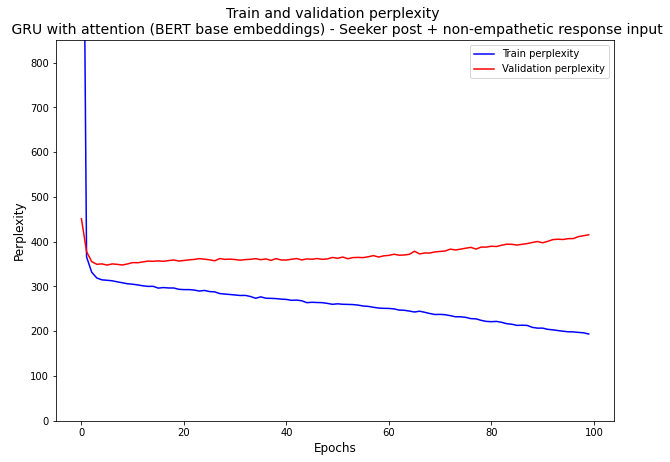

In [ ]:
#plot train and validation PPL logs

fig = plt.figure(figsize=(10,7))

y1 = tr['PPL']
y2 = val['PPL']

plt.plot(y1, "-b", label="Train perplexity")
plt.plot(y2, "-r", label="Validation perplexity")
plt.legend(loc="upper right")
plt.ylim(0, 850)
plt.ylabel('Perplexity', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Train and validation perplexity \n GRU with attention (BERT base embeddings) - Seeker post + non-empathetic response input", fontsize = 14)

fig.savefig("2b-ppl.pdf")
plt.show()

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/tut3-model-2c.pt'))

test_loss_2b = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss_2b:.3f} | Test PPL: {math.exp(test_loss_2b):7.3f} |')

| Test Loss: 5.797 | Test PPL: 329.175 |


In [ ]:
def generate_sentence(model, iterator):
    
    model.eval()
    
    epoch_loss = 0

    pred_trg_pairs = []

    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[:,1:]
            trg = trg[:,1:]

            output = output.detach().cpu().numpy()
            trg = trg.detach().cpu().numpy()
            pred= np.argmax( output , axis = -1 )

            pred = tokenizer.batch_decode( pred , skip_special_tokens=True)
            trg = tokenizer.batch_decode( trg , skip_special_tokens = True )

            for i_pred , i_trg in zip( pred , trg  ):

              print( "Target Sentence : {} \n".format( i_trg )  )
              print( "Predicted Sentence : {} \n".format( i_pred )  )

            break

In [ ]:
generate_sentence(model, test_loader)

Target Sentence : . must have meant so much to give yourself to a relationship where that loss hurts this bad. crap, that's quite the level of commitment!, that is something to hang your hat on. have that in you, right? did it once before. shit hurts right now but you have it in you!!. cant imagine how happy you will be when you find the next one... maybe one that fits the possibility of a promising relationship?, think you have a good base here. 

Predicted Sentence :  

Target Sentence : feel only bad things, too. can laugh and joke with my buddies, but it just feels hollow and empty on the inside. even come to think, that often times smile and laugh, cause know a normal person would do this and did it once, so to don't look like a freak, do it at the right times.'m never excited these days. can't even remember the last time was. when decided to lose my virginity to a prostitute when was around 30, had some concerns but wasn't excited. and partys, knew couldn't wait for some when was